# 0. 초기 셋업

In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# ETF 데이터 다운로드
data = yf.download('SPY TLT', start='2002-07-30')
data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1)
rets = data.pct_change().fillna(0)

[*********************100%***********************]  2 of 2 completed


# 1. 샤프비율 (Sharpe Ratio)

첫 번째 성과지표는 바로 샤프비율입니다. 샤프비율은 가장 보편적으로 사용되는 성과지표이기 때문에 금융투자업에 종사하고 있다면 어딜가나 쉽게 접할 수 있는 지표입니다. 샤프비율은 성과를 평균수익률로 위험을 표준편차로 정의하고 있습니다. 따라서 샤프비율을 계산하는 공식은 다음과 같습니다.

샤프비율
$$ Sharpe = \frac{μ_{p} - r_{f}}{σ_{p}} $$

여기서 각각 $\mu_{p}$는 포트폴리오의 평균수익률, $r_{f}$는 무위험수익률, $σ_{p}$는 포트폴리오의 변동성을 의미합니다. 무위험수익률이란 예금 수익률과 같이 아무런 위험 부담을 가지지 않는 무위험자산의 수익률을 의미하는데, 앞으로의 논의에서는 이 무위험수익률을 0이라고 가정하겠습니다. 그렇게 되면 샤프비율의 계산은 단순히 포트폴리오 평균수익률을 포트폴리오 변동성으로 나눈 값이 되고, 샤프비율의 의미는 변동성을 한 단위 부담할 때 얻을 수 있는 수익의 크기가 됩니다. 

한 가지 주의할 점은 다른 성과지표도 마찬가지이지만 수익과 위험을 측정하는 시간의 기준이 동일해야 한다는 것입니다. 그렇기 때문에 일반적으로는 모든 지표를 연율화하여 계산을 하고 있습니다.

파이썬을 활용해 SPY와 TLT, 두 ETF의 샤프비율을 계산해보고 이를 시각화해보도록 하겠습니다.

In [3]:
# 샤프비율 계산
sharpe_ratio = rets.mean() * np.sqrt(252) / rets.std()
spy_sharpe_ratio = sharpe_ratio[0]
tlt_sharpe_ratio = sharpe_ratio[1]

print(spy_sharpe_ratio)
print(tlt_sharpe_ratio)

0.5837584610134608
0.38242560311425944


전체 샤프비율을 계산해보았다면 이제는 1년 단위 기준의 롤링 샤프비율도 계산해보겠습니다. 롤링 샤프비율을 계산하는 것 또한 `rolling()` 메서드를 사용한다는 점을 제외한다면 위와 마찬가지 방식입니다.

In [4]:
# 1년 롤링 샤프비율 계산
lookback = 252
rolling_sharpe_ratio = rets.rolling(lookback).mean() * np.sqrt(252) / rets.rolling(lookback).std()

spy_rolling_sharpe = rolling_sharpe_ratio['SPY']
tlt_rolling_sharpe = rolling_sharpe_ratio['TLT']


마지막으로 롤링 샤프비율과 전체 샤프비율을 그래프로 시각화해보겠습니다. 범례에는 전체 기간의 샤프비율이 표시되고 있습니다. `numpy`의 `round()` 메서드를 사용해 샤프비율을 소수점 둘째자리까지만 반올림하여 표시해줍니다.

Text(0, 0.5, '1-Year Rolling Sharpe Ratio')

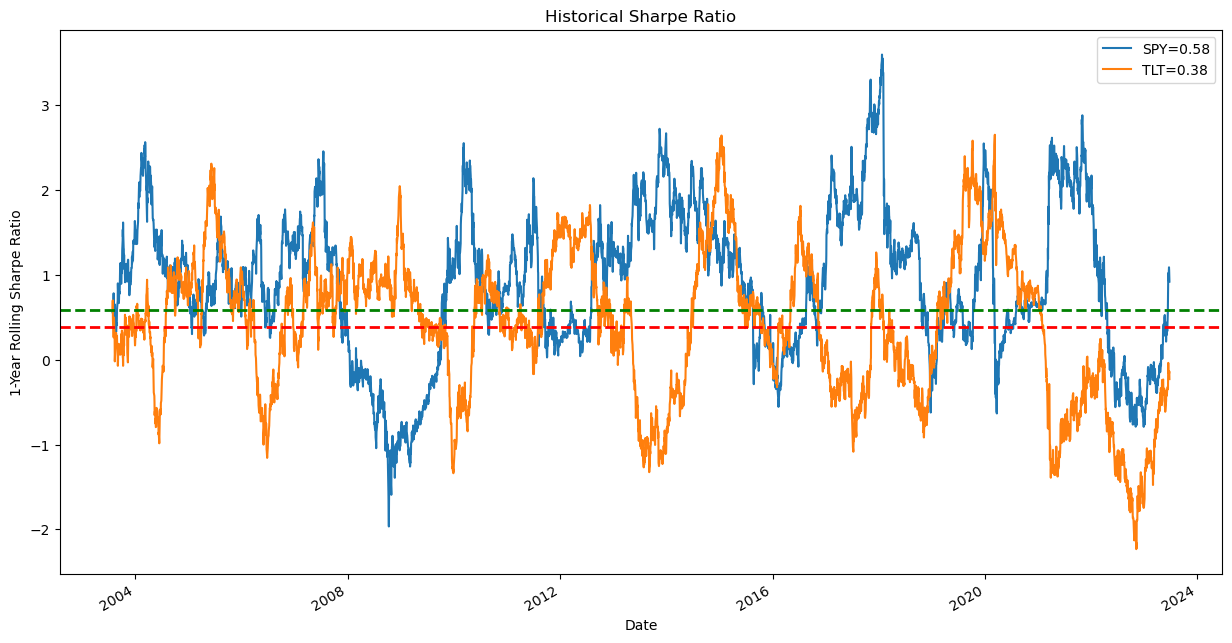

In [5]:
# 샤프비율 시각화
plt.figure(figsize=(15, 8))
spy_rolling_sharpe.plot(label='SPY={}'.format(np.round(spy_sharpe_ratio, 2)))
tlt_rolling_sharpe.plot(label='TLT={}'.format(np.round(tlt_sharpe_ratio, 2)))
plt.axhline(spy_sharpe_ratio, color='g', linestyle='dashed', linewidth=2)
plt.axhline(tlt_sharpe_ratio, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.title('Historical Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('1-Year Rolling Sharpe Ratio')

# 2. 소르티노 비율 (Sortino Ratio)

두 번째 성과지표는 소르티노 비율입니다. 소르티노 비율과 샤프비율의 차이점은 분모에 위험지표를 무엇을 사용할 것인가 입니다. 샤프비율은 일반적인 표준편차를 위험지표로 사용했다면, 여기 소르티노 비율의 경우 하방 표준편차를 위험지표로 사용하고 있습니다. 따라서 소르티노 비율의 공식은 다음과 같습니다.

소르티노 비율
$$ Sortino = \frac{μ_{p} - r_{f}}{Dσ_{p}} $$

파이썬으로 소르티노 비율을 구현해보겠습니다. 우선 각 종목의 하방표준편차를 계산하기 위해 수익률 데이터프레임을 각 종목별로 분리해보겠습니다.

In [6]:
# 각 ETF의 수익률 데이터
spy_rets = rets['SPY']
tlt_rets = rets['TLT']

# 수익률 데이터 복사
spy_rets_copy = spy_rets.copy()
tlt_rets_copy = tlt_rets.copy()

# 수익률이 플러스라면 0으로 변환
spy_rets_copy[spy_rets_copy >= 0] = 0
tlt_rets_copy[tlt_rets_copy >= 0] = 0

# 하방 표준편차 계산
spy_down_dev = spy_rets_copy.std() * np.sqrt(252)
tlt_down_dev = tlt_rets_copy.std() * np.sqrt(252)

하방 표준편차를 계산했다면 그 다음에는 소르티노 비율을 계산합니다.

In [7]:
# 소르티노 비율 계산
spy_sortino = spy_rets.mean() * 252 / spy_down_dev
tlt_sortino = tlt_rets.mean() * 252 / tlt_down_dev

In [8]:
print(spy_sortino)
print(tlt_sortino)

0.9143415774320653
0.6417160397382892


또한 1년 롤링 소르티노 비율도 계산해줍니다.

In [9]:
# 1년 롤링 소르티노 비율 계산
lookback = 252
spy_rolling_sortino = spy_rets.rolling(lookback).mean() * np.sqrt(252) / spy_rets_copy.rolling(lookback).std()
tlt_rolling_sortino = tlt_rets.rolling(lookback).mean() * np.sqrt(252) / tlt_rets_copy.rolling(lookback).std()

마지막으로 소르티노 비율에 대한 그래프를 그려줍니다.

Text(0.5, 1.0, 'Historical Sortino Ratio')

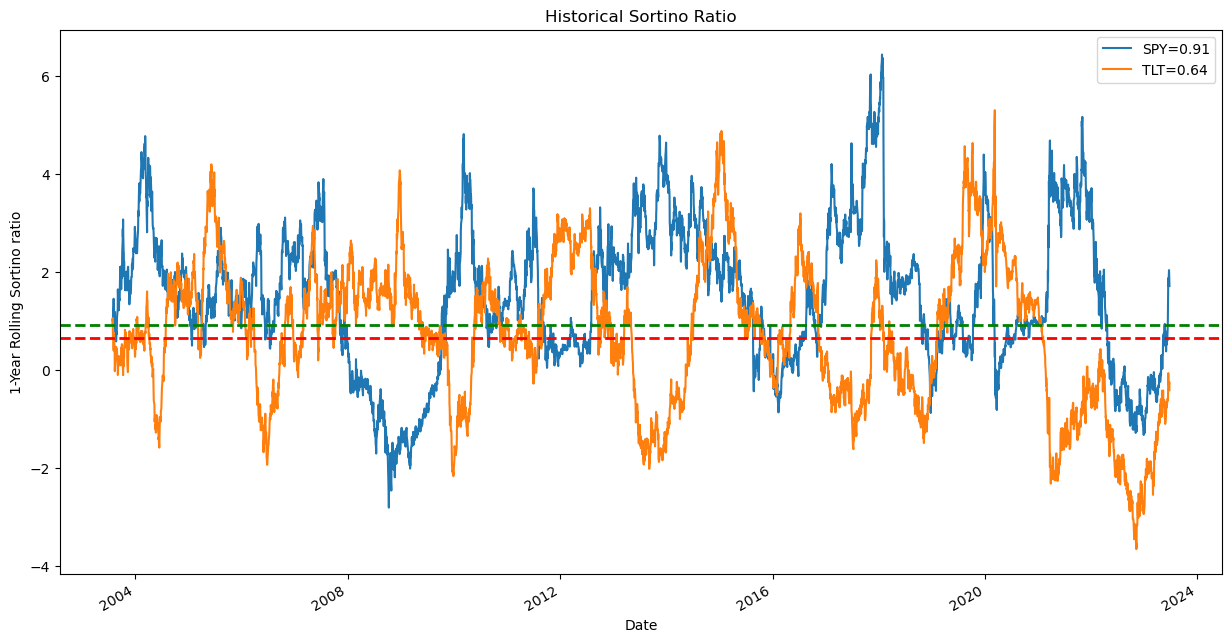

In [10]:
# 소르티노 비율 시각화
plt.figure(figsize=(15,8))
spy_rolling_sortino.plot(label='SPY={}'.format(np.round(spy_sortino, 2)))
tlt_rolling_sortino.plot(label='TLT={}'.format(np.round(tlt_sortino, 2)))
plt.axhline(spy_sortino, color='g', linestyle='dashed', linewidth=2)
plt.axhline(tlt_sortino, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel('Date')
plt.ylabel('1-Year Rolling Sortino ratio')
plt.title('Historical Sortino Ratio')

# 3. 칼마 비율 (Calmar Ratio)

세 번째 성과지표는 칼마 비율입니다. 칼마 비율이 생각하는 위험 지표는 바로 최대낙폭, 즉 MDD입니다. 따라서 칼마 비율의 공식은 다음과 같습니다.

칼마 비율
$$ Calmar = -\frac{μ_{p} - r_{f}}{MDD_{p}} $$

칼마 비율을 계산할 때 한 가지 주의해야 할 점은 일반적으로 최대낙폭이 마이너스 값일 것이기 때문에 칼마 비율을 계산할 때 앞에 마이너스를 붙여주어 다른 성과지표들과 같은 방향성을 띄게 만들어주어야 한다는 점입니다. 이렇게 되면 칼마 비율 또한 값이 높아질수록 좋은 성과를, 값이 낮아질수록 나쁜 성과를 나타내주게 됩니다. 또한 롤링 칼마비율을 계산할 때는 통상적으로 3년치 데이터를 가지고 최대낙폭을 계산합니다. 

파이썬으로 칼마비율을 계산해보도록 하겠습니다.

In [11]:
# 낙폭 계산
dd = data / data.cummax() - 1

In [12]:
# 각 ETF 별 칼마 비율 계산
spy_calmar = - spy_rets.mean() * 252 / dd['SPY'].min()
tlt_calmar = - tlt_rets.mean() * 252 / dd['TLT'].min()

print(spy_calmar)
print(tlt_calmar)

0.2039733008783532
0.12440593224889088


전체 기간에 대한 칼마비율을 계산했으니 이제는 1년 롤링 칼마 비율을 계산해보겠습니다. 이 때 롤링 평균수익률의 윈도우는 1년이지만, 롤링 MDD는 3년을 사용하겠습니다.

In [13]:
# 수익률 롤링 윈도우
lookback = 252

# 1년 롤링 칼마비율 계산
spy_rolling_calmar = - spy_rets.rolling(lookback).mean() * 252 / dd['SPY'].rolling(lookback * 3).min()
tlt_rolling_calmar = - tlt_rets.rolling(lookback).mean() * 252 / dd['TLT'].rolling(lookback * 3).min()

마지막으로 칼마비율을 그래프로 시각화해보겠습니다.

Text(0.5, 1.0, 'Historical Calmar Ratio')

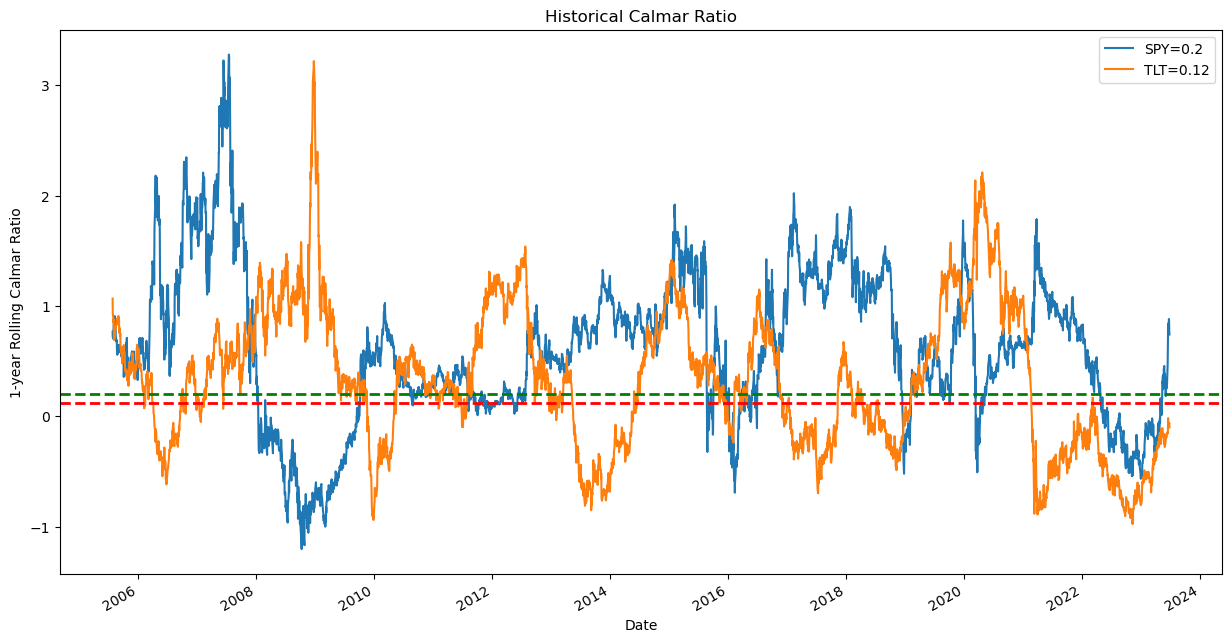

In [14]:
# 칼마비율 시각화
plt.figure(figsize=(15, 8))
spy_rolling_calmar.plot(label='SPY={}'.format(np.round(spy_calmar, 2)))
tlt_rolling_calmar.plot(label='TLT={}'.format(np.round(tlt_calmar, 2)))
plt.axhline(spy_calmar, color='g', linestyle='dashed', linewidth=2)
plt.axhline(tlt_calmar, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel('Date')
plt.ylabel('1-year Rolling Calmar Ratio')
plt.title('Historical Calmar Ratio')

# 4. VaR 대비 성과 비율 (Reward-to-VaR Ratio)

네 번째 성과지표는 VaR 대비 성과 비율입니다. 지표의 이름이 제시하고 있는 것처럼 여기서의 위험지표는 VaR를 사용합니다. VaR 대비 성과 비율의 계산 공식은 다음과 같습니다.

VaR 대비 성과 비율
$$ VaR Ratio = -\frac{\mu_{p} - r_{f}}{N * VaR_{δ, p}} $$

이것을 계산할 때 주의할 점은 크게 두 가지입니다. 하나는 칼마비율과 같이 VaR을 마이너스로 계산하는 경우가 있기 때문에 지표를 양수로 만들기 위해서는 마이너스를 붙여주어야 한다는 것입니다. 또 하나는 평균 수익률과 VaR의 기간을 동일하게 만들어주어야 한다는 것입니다. 평균 수익률은 이미 연율화가 되어있는 개념이므로, 이와 동일하게 기준을 맞춰주기 위해서는 VaR 값 또한 N을 곱하여 연율화를 해주어야 합니다.

파이썬으로 이 성과지표를 구현해보겠습니다.


In [15]:
# VaR 계산
delta = 0.01
spy_VaR = spy_rets.quantile(delta)
tlt_VaR = tlt_rets.quantile(delta)

In [16]:
# VaR 대비 성과 비율 계산
spy_VaR_ratio = - spy_rets.mean() / spy_VaR
tlt_VaR_ratio = - tlt_rets.mean() / tlt_VaR

In [17]:
print(spy_VaR_ratio)
print(tlt_VaR_ratio)

0.012845936941938496
0.009625608521524517


1년 롤링 VaR 대비 성과 비율 또한 계산해줍니다.

In [18]:
# 1년 롤링 VaR 대비 성과 비율 계산
lookback = 252
spy_rolling_VaR_ratio = spy_rets.rolling(lookback).mean() / - spy_rets.rolling(lookback).quantile(delta)
tlt_rolling_VaR_ratio = tlt_rets.rolling(lookback).mean() / - tlt_rets.rolling(lookback).quantile(delta)

마지막으로 이를 시각화해줍니다.

Text(0.5, 1.0, 'Historical Reward-to-VaR Ratio')

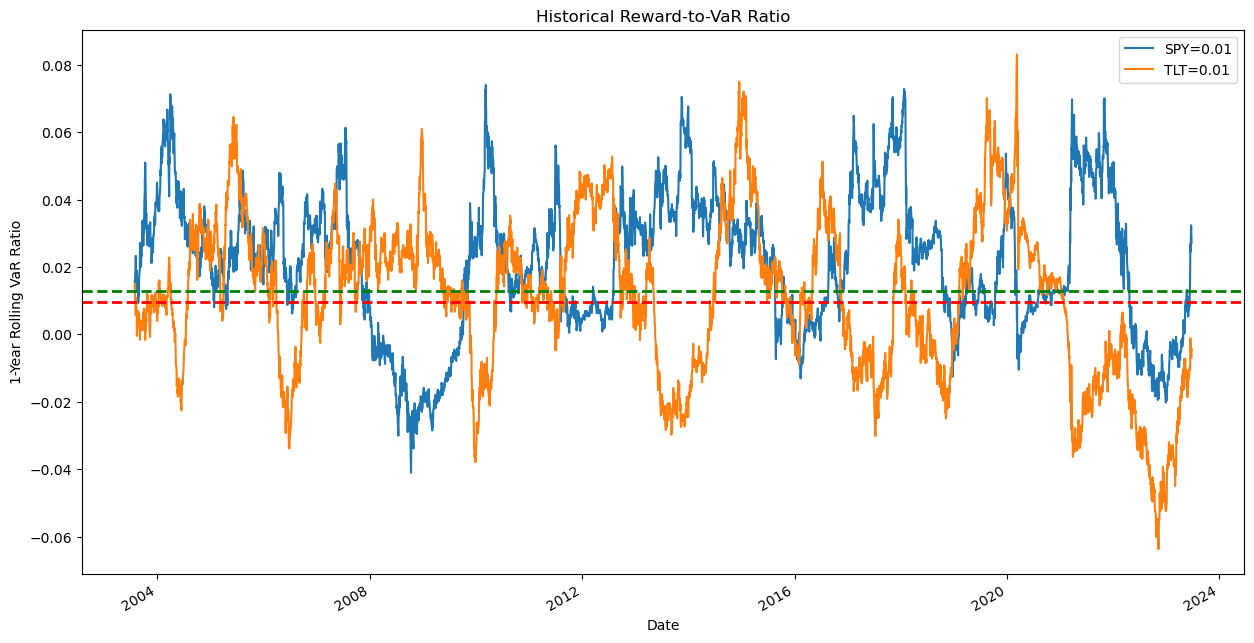

In [19]:
# VaR 대비 성과 비율 시각화
plt.figure(figsize=(15, 8))
spy_rolling_VaR_ratio.plot(label='SPY={}'.format(np.round(spy_VaR_ratio, 2)))
tlt_rolling_VaR_ratio.plot(label='TLT={}'.format(np.round(tlt_VaR_ratio, 2)))
plt.axhline(spy_VaR_ratio, color='g', linestyle='dashed', linewidth=2)
plt.axhline(tlt_VaR_ratio, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel('Date')
plt.ylabel('1-Year Rolling VaR Ratio')
plt.title('Historical Reward-to-VaR Ratio')

# 5. CVaR 대비 성과 비율 (Reward-to-CVaR Ratio)

다섯 번째 성과지표는 위에서 다루었던 VaR 대비 성과 비율과 유사한 CVaR 대비 성과 비율입니다. 여기서의 위험지표는 당연히 CVaR이기 때문에 이를 계산하기 위한 공식은 다음과 같습니다.

CVaR 대비 성과 비율
$$ CVaR Ratio = -\frac{μ_{p} - r_{f}}{CVaR_{δ, p}} $$

파이썬으로 이를 구현해보겠습니다. 우선 CVaR를 계산하기 위한 함수를 만들어주어야합니다. 그 이유는 이 함수가 롤링 CVaR를 계산하기 위해 계속 필요하기 때문입니다.

In [20]:
def calculate_CVaR(rets, delta=0.01):
    VaR = rets.quantile(delta)
    return rets[rets <= VaR].mean()

그 다음에는 전체 기간에 대한 CVaR 대비 성과 비율을 계산해보겠습니다. 앞서 구현해놓았던 함수를 사용하면 손쉽게 CVaR를 계산할 수 있습니다.

In [21]:
# CVaR 계산
spy_CVaR = calculate_CVaR(spy_rets)
tlt_CVaR = calculate_CVaR(tlt_rets)

# CVaR 대비 성과 비율 계산
spy_CVaR_ratio = spy_rets.mean() / -spy_CVaR
tlt_CVaR_ratio = tlt_rets.mean() / -tlt_CVaR

print(spy_CVaR_ratio)
print(tlt_CVaR_ratio)

0.008831117775195702
0.0075193897279203295


1년 롤링 CVaR 대비 성과 비율도 계산을 해보겠습니다. 1년 단위로 윈도우를 하나씩 옮기면서 매번 CVaR를 계산해주어야 하는 것이 언뜻 생각해보면 어려울 수 있습니다. 하지만 `pandas`에는 `apply()`라는 메서드가 있기 때문에 이를 활용한다면 생각보다 쉽게 롤링 CVaR를 계산할 수 있습니다. 이 `apply()`라는 메서드는 인자에 어떤 함수를 입력받게 되고 롤링으로 가져오는 데이터들을 해당 함수에 넣어 계산을 수행할 수 있도록 만들어줍니다. 여기에서는 `apply()` 메서드 안에 앞서 구현했던 `calculate_CVaR`라는 함수가 인자로 들어갔습니다. 매번 롤링을 하면서 함수를 계산해야 하기 때문에 아래의 코드를 실행하면 약 10초 정도의 시간이 걸립니다.

In [22]:
# 1년 롤링 CVaR 대비 성과 비율 계산
lookback = 252
spy_rolling_CVaR_ratio = spy_rets.rolling(lookback).mean() / -spy_rets.rolling(lookback).apply(calculate_CVaR)
tlt_rolling_CVaR_ratio = tlt_rets.rolling(lookback).mean() / -tlt_rets.rolling(lookback).apply(calculate_CVaR)

이제 롤링 CVaR 대비 성과 비율의 계산이 완료되었으니 이를 그래프로 그려보겠습니다.

Text(0.5, 1.0, 'Historical Reward-to-CVaR Ratio')

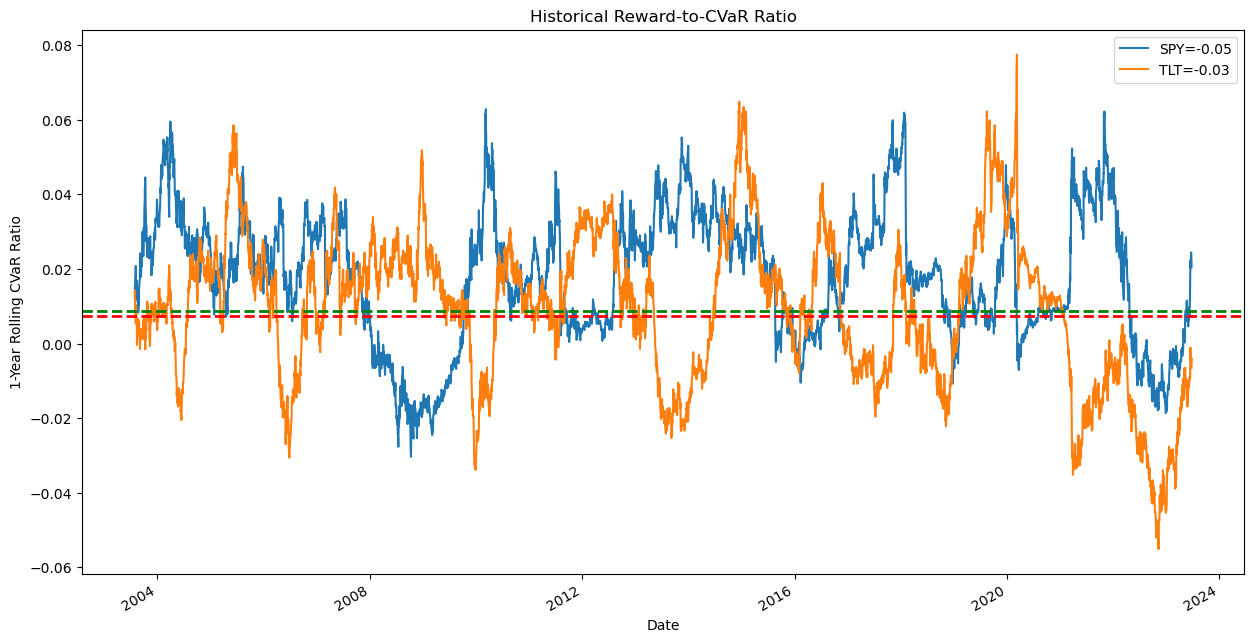

In [23]:
# CVaR 대비 성과 비율 시각화
plt.figure(figsize=(15, 8))
spy_rolling_CVaR_ratio.plot(label='SPY={}'.format(np.round(spy_CVaR, 2)))
tlt_rolling_CVaR_ratio.plot(label='TLT={}'.format(np.round(tlt_CVaR, 2)))
plt.axhline(spy_CVaR_ratio, color='g', linestyle='dashed', linewidth=2)
plt.axhline(tlt_CVaR_ratio, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel('Date')
plt.ylabel('1-Year Rolling CVaR Ratio')
plt.title('Historical Reward-to-CVaR Ratio')

# 6. 승률(Hit Ratio)과 손익비(Gain-to-Pain Ratio)

마지막 성과지표는 승률과 손익비입니다. 승률과 손익비는 위험 대비 성과를 가정하고 있는 지표는 아니지만, 어떤 트레이딩 전략 혹은 투자 전략이 확률적으로 계산했을 때 어느 정도의 성과를 보이는지를 체크하기 위한 성과지표입니다.

우선 승률입니다. 승률은 전체 매매를 한 횟수 중에서 실제로 이익이 난 매매 횟수의 비율을 의미합니다. 예를 들어, 승률이 60%다라고 한다면 전체 100번의 매매를 했을 때 60번은 수익이 났고, 나머지 40번은 손실이 났다는 것을 의미합니다. 따라서 승률은 다음과 같은 공식을 사용해 계산할 수 있습니다.

승률
$$ HR = \frac{Σ_{i=1}^{N}1_{\{r_{i}>0\}}}{N} $$

그다음은 손익비입니다. 손익비라는 개념은 말그대로 손실과 이익의 비율을 의미합니다. 이는 승률과는 다르게 몇 번 이겼냐 졌냐를 따지는 것이 아닌 이겼을 때 얼마나 크게 이겼고, 졌을 때 얼마나 크게 졌나를 따집니다. 손익비는 1회당 평균 이익 금액, 즉 전체 이익 금액의 평균에서 1회당 평균 손실 금액, 즉 전체 손실 금액의 평균을 나누어주면 됩니다. 물론 마지막에는 이 값에 마이너스를 붙여주어야 하는데요. 1회당 평균 손실 금액이 음수이기 때문입니다. 이렇게 손익비를 계산했을 때 당연히 이 수치가 높으면 높을수록 좋은 성과라고 할 수 있습니다. 예를 들어, 손익비가 3이라고 한다면 한 번 손실보았을 때의 손실금액보다 한 번 수익을 얻었을때의 이익금액이 확률적으로 3배 더 크다는 것을 의미합니다. 손익비는 다음과 같은 공식을 사용해 계산할 수 있습니다.

손익비
$$ GPR = -\frac{Σ_{i=1}^{N}max(r_{i}, 0)}{Σ_{i=1}^{N}min(r_{i}, 0)} $$

우리는 승률과 손익비를 사용해 어떤 투자 전략의 확률적 우위를 계산해볼 수 있습니다. 여기서 말하는 확률적 우위란 이 게임이 장기적으로 나에게 유리하게 형성되었는지를 판단하는 지표입니다. 만약 나에게 확률적 우위가 없다면, 즉 이 값이 마이너스라면 우리는 해당 전략을 사용해서는 안됩니다. 장기적으로 손실을 보게 되기 때문입니다. 확률적 우위가 플러스가 되기 위한 조건을 승률과 손익비로 표현하자면 다음과 같이 나타낼 수 있습니다.

확률적 우위가 존재하기 위한 조건
$$ GPR > \frac{1 - HR}{HR} $$

만약 승률과 손익비를 계산했을 때 위의 조건을 만족하지 못한다고 한다면 장기적으로 승산이 없는 전략이기 때문에 우리는 해당 전략을 전면 재검토해야 할 필요성이 있습니다.

이제 파이썬을 활용해서 이 승률과 손익비를 계산해보도록 하겠습니다. 우선 수익률 데이터를 집어넣으면 승률을 계산해 주는 함수를 작성합니다.

In [24]:
# 승률 계산 함수
def calculate_hit_ratio(rets):
    return len(rets[rets > 0.0]) / len(rets[rets != 0.0])

위의 함수를 사용해 전체 기간에 대한 승률을 계산합니다.

In [25]:
# 승률 계산
spy_hit_ratio = calculate_hit_ratio(spy_rets)
tlt_hit_ratio = calculate_hit_ratio(tlt_rets)

print(spy_hit_ratio)
print(tlt_hit_ratio)

0.5506582713222667
0.5265571264807031


롤링 승률에 대해서도 계산을 해볼 수 있습니다. CVaR 대비 성과 비율을 계산했을 때와 마찬가지로 `pandas`의 `apply()` 메서드를 사용하여 롤링 승률을 계산합니다.

In [26]:
# 롤링 승률 계산
spy_rolling_hit_ratio = spy_rets.rolling(252).apply(calculate_hit_ratio)
tlt_rolling_hit_ratio = tlt_rets.rolling(252).apply(calculate_hit_ratio)

마지막으로 이를 그래프로 그려줍니다.

Text(0.5, 1.0, 'Historical Hit Ratio')

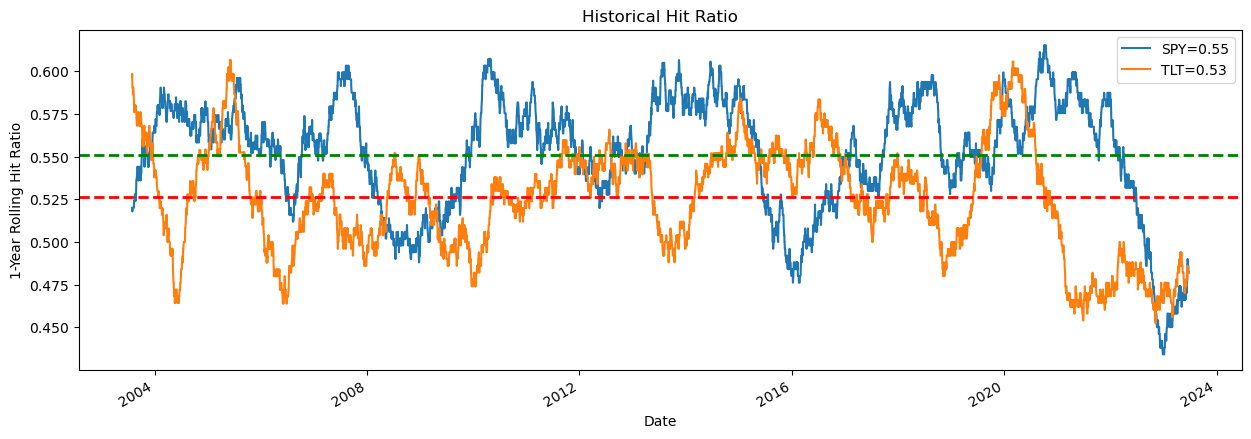

In [27]:
# 승률 시각화
plt.figure(figsize=(15, 5))
spy_rolling_hit_ratio.plot(label='SPY={}'.format(np.round(spy_hit_ratio, 2)))
tlt_rolling_hit_ratio.plot(label='TLT={}'.format(np.round(tlt_hit_ratio, 2)))
plt.axhline(spy_hit_ratio, color='g', linestyle='dashed', linewidth=2)
plt.axhline(tlt_hit_ratio, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel('Date')
plt.ylabel('1-Year Rolling Hit Ratio')
plt.title('Historical Hit Ratio')

그 다음은 손익비를 계산하는 함수를 작성해보겠습니다.

In [28]:
# 손익비 계산 함수
def calculate_gtp_ratio(rets):
    return rets[rets > 0.0].mean() / -rets[rets < 0.0].mean()

위의 함수를 사용해 전체 기간에 대한 손익비를 계산합니다.

In [29]:
# 손익비 계산
spy_gtp_ratio = calculate_gtp_ratio(spy_rets)
tlt_gtp_ratio = calculate_gtp_ratio(tlt_rets)

print(spy_gtp_ratio)
print(tlt_gtp_ratio)

0.9140121130464038
0.9592295591904003


그 다음에는 롤링 손익비를 계산합니다.

In [30]:
# 롤링 손익비 계산
spy_rolling_gtp_ratio = spy_rets.rolling(252).apply(calculate_gtp_ratio)
tlt_rolling_gtp_ratio = tlt_rets.rolling(252).apply(calculate_gtp_ratio)

마지막으로 이를 그래프로 그려줍니다.

Text(0.5, 1.0, 'Historical Gain-to-Pain Ratio')

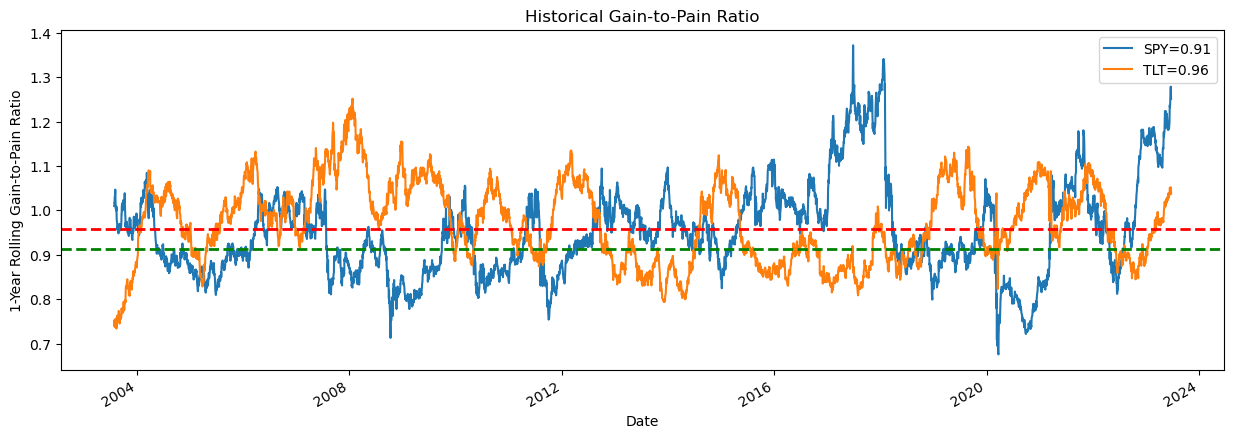

In [31]:
# 손익비 시각화
plt.figure(figsize=(15, 5))
spy_rolling_gtp_ratio.plot(label='SPY={}'.format(np.round(spy_gtp_ratio, 2)))
tlt_rolling_gtp_ratio.plot(label='TLT={}'.format(np.round(tlt_gtp_ratio, 2)))
plt.axhline(spy_gtp_ratio, color='g', linestyle='dashed', linewidth=2)
plt.axhline(tlt_gtp_ratio, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel('Date')
plt.ylabel('1-Year Rolling Gain-to-Pain Ratio')
plt.title('Historical Gain-to-Pain Ratio')

SPY와 TLT에 대한 각각의 승률과 손익비를 구했으니 마지막으로 두 자산의 확률적 우위가 있는지를 한 번 검증해볼까요? 확률적 우위가 존재하기 위한 조건이 참인지 거짓인지를 출력해보면 해당 ETF를 장기적으로 바이앤홀드 했던 것이 잘한 일이었는지 그렇지 못한 일이었는지를 직관적으로 파악할 수 있습니다. 두 ETF에 대한 확률적 우위 존재 유무를 한 번 파이썬으로 구현해보겠습니다.

In [32]:
# SPY 확률적 우위 검증
spy_TE = spy_gtp_ratio > (1 - spy_hit_ratio) / spy_hit_ratio
print(spy_TE)

True


In [33]:
# TLT 확률적 우위 검증
tlt_TE = tlt_gtp_ratio > (1 - tlt_hit_ratio) / tlt_hit_ratio
print(tlt_TE)

True


두 ETF 모두 확률적 우위가 존재하는군요. 이 두 ETF에 대해 바이앤홀드는 하는 것이 장기적으로 의미가 있는 투자방법임을 알 수 있습니다.